In [27]:
import numpy as np
from matplotlib import pyplot as plt


def make_strategies(rng, strategies, memory):
    # weights should sum to 1
    # essentially, we are partitioning the [0,1] interval
    # and taking the size of each sub-interval
    # TODO: add negative weights?
    w = rng.uniform(size=(strategies, memory-1))
    w.sort(axis=1)
    offsets = np.hstack([w[:, :], np.ones(shape=(strategies,1))])
    return offsets - np.hstack([np.zeros(shape=(strategies,1)), w[:, :]])


def run_simulation(
    agents = 100, # number of agents
    threshold = 60, # threshold for attendance
    strategies = 10, # number of strategies
    # number of weeks back in predictor function
    # AND number of weeks back to look when selecting a predictor
    memory = 8,
    # number of rounds to run the simulation
    n_iter = 500,
    # random seed for numpy
    seed=23
):
    """
    Run a simulation of the El Farol Bar Problem
    for *n_iter* weeks.  Return the weekly attendance history,
    the strategy chosen by each agent, and the prediction
    made by each agent each week using their optimal predictor.
    """
    rng = np.random.default_rng(seed)

    # each row is a strategy
    strats = [
        make_strategies(rng, strategies, memory) for _ in range(agents)
    ]

    start = rng.uniform(agents, size=(memory*2))

    # weekly attendance count
    # the first 2*memory weeks are randomly generated
    # to seed the strategies
    hist = np.hstack([start, np.zeros(n_iter)]).astype(int)

    # index of week
    # we need some starting history to begin making selections
    t = memory * 2

    # Record the index of the optimal strategy 
    # on each iteration.
    # each row corresponds to an agent
    # each column corresponds to a week
    best_strats = np.zeros((agents, len(hist)))

    # record each agent's prediction on each iteration
    pred_history = np.zeros((agents, len(hist)))

    while t < memory * 2 + n_iter:
        
        # construct time windows for evaluating strategies
        
        # The columns begin at
        # t - m - 1 
        # t - m
        # ...
        # t - 1
        # t
        # as you go down the column you are looking back
        # to that week's history.
        # so the column beginning at *t - m - 1*
        # generates the prediction for week *t - m*
        # and the rightmost column generates a
        # prediction for next week.
        windows = np.vstack([
            hist[t-memory-i-1: t-i]
            for i in range(memory)
        ])

        for agent in range(agents):
            strat = strats[agent]
            # each row is a strategy
            # each column is predicted attendance
            # in increasing order.
            # the last column has the prediction for
            # next week
            predictions = strat.dot(windows)
            
            # these are the observations that we use to
            # to test our predictions.
            # note that the observation from column 0
            # is not used since its prediction would come
            # from a previous week's history.
            observations = windows[0, 1:]

            # calculate the absolute error of predictions
            # here, we discard the rightmost prediction as
            # this is the prediction for the future.
            # if we knew the correct answer for that,
            # we wouldn't need to predict it!
            errs = np.abs(predictions[:, :-1] - observations).sum(axis=1)

            best_strat = np.argmin(errs)
            best_strats[agent, t] = best_strat

            pred = strat[best_strat].dot(windows[:,-1])
            pred_history[agent, t] = pred

        hist[t] = (pred_history[:, t] < threshold).sum()
        t += 1
        
    return hist, best_strats, pred_history

In [11]:
agents = 100 # number of agents
threshold = 60 # threshold for attendance
strategies = 2 # number of strategies
# number of weeks back in predictor function
# AND number of weeks back to look when selecting a predictor
memory = 2
# number of rounds to run the simulation
n_iter = 1
# random seed for numpy
seed=25


rng = np.random.default_rng(seed)

# each row is a strategy
strats = [
    make_strategies(rng, strategies, memory) for _ in range(agents)
]

start = np.array([0,100,0,100])

# weekly attendance count
# the first 2*memory weeks are randomly generated
# to seed the strategies
hist = np.hstack([start, np.zeros(n_iter)]).astype(int)

# index of week
# we need some starting history to begin making selections
t = memory * 2

# Record the index of the optimal strategy 
# on each iteration.
# each row corresponds to an agent
# each column corresponds to a week
best_strats = np.zeros((agents, len(hist)))

# record each agent's prediction on each iteration
pred_history = np.zeros((agents, len(hist)))

# construct time windows for evaluating strategies

# The columns begin at
# t - m - 1 
# t - m
# ...
# t - 1
# t
# as you go down the column you are looking back
# to that week's history.
# so the column beginning at *t - m - 1*
# generates the prediction for week *t - m*
# and the rightmost column generates a
# prediction for next week.
windows = np.vstack([
    hist[t-memory-i-1: t-i]
    for i in range(memory)
])

for agent in range(agents):
    strat = strats[agent]
    # each row is a strategy
    # each column is predicted attendance
    # in increasing order.
    # the last column has the prediction for
    # next week
    predictions = strat.dot(windows)

    # these are the observations that we use to
    # to test our predictions.
    # note that the observation from column 0
    # is not used since its prediction would come
    # from a previous week's history.
    observations = windows[0, 1:]

    # calculate the absolute error of predictions
    # here, we discard the rightmost prediction as
    # this is the prediction for the future.
    # if we knew the correct answer for that,
    # we wouldn't need to predict it!
    errs = np.abs(predictions[:, :-1] - observations).sum(axis=1)

    best_strat = np.argmin(errs)
    best_strats[agent, t] = best_strat

    pred = strat[best_strat].dot(windows[:,-1])
    pred_history[agent, t] = pred

hist[t] = (pred_history[:, t] < threshold).sum()
t += 1

In [12]:
hist

array([  0, 100,   0, 100,  85])

WHAT?????

# Check assumptions
## Coefficients sum to 1

In [13]:
for strat in strats:
    for i in range(2):
        assert strats[i].sum() - 1 < 1e010

OK that's fine
## Are agents picking the highest a?

In [20]:
for strat, choice in zip(strats, best_strats[:, -1]):
    c = int(choice)
    a_1 = strat[c, 0]
    
    # not chosen
    nc = (c + 1) % 2
    a_bad = strat[nc, 0]
    
    assert a_1 > a_bad
    
print("Largest always picked!")

AssertionError: 

In [21]:
for strat, choice in zip(strats, best_strats[:, -1]):
    c = int(choice)
    a_1 = strat[c, 0]
    
    # not chosen
    nc = (c + 1) % 2
    a_bad = strat[nc, 0]
    
    assert a_1 < a_bad
    
print("Smallest always picked?!?!")

Smallest always picked?!?!


Something is still wrong.  But we are making progress!

In [34]:
windows

array([[100,   0, 100],
       [  0, 100,   0]])

In [33]:
strats[-1]

array([[0.51056717, 0.48943283],
       [0.91127415, 0.08872585]])

In [31]:
predictions

array([[51.05671669, 48.94328331, 51.05671669],
       [91.1274154 ,  8.8725846 , 91.1274154 ]])

In [32]:
observations

array([  0, 100])

In [36]:
predictions[:, :-1] - observations

array([[ 51.05671669, -51.05671669],
       [ 91.1274154 , -91.1274154 ]])

In [40]:
errs

array([102.11343339, 182.2548308 ])

In [39]:
predictions[:, :-1].sum(axis=1)

array([100., 100.])

Wait, this IS right!  The columns are in decreasing order so the leftmost weight IS attached to the most recent week.  Before I just had the off-by-one error and the backwards order cancel each other out.  We are okay I think.

We pick the smallest $a$ and use that to predict.  So the probability of an agent attending after history (0, 100, 0, 100) is:

$$
P(\text{prediction} < 60) \\
= P(100 a_{min} < 60) \\
= 1 - P(a_{min} > 0.6) \\
= 1 - P(a > 0.6)^S \\
= 1 - 0.4^S \\
$$

With history (100, 0, 100, 0), the probability of attending is:

$$
P(\text{prediction} < 60) \\
= P(100 (1 - a_{min}) < 60) \\
= P(1 - a_{min}) < 0.6) \\
= P(0.4 < a_{min}) \\
= P(a_{min} > 0.4) \\
= P(a > 0.4)^S
= 0.6^S
$$

Is this what we get?

We expect agents to attend with probability 0.84.
Total weekly attendance should have mean 84.0 and variance 13.440000000000003
Average attendance: 84.0734
Variance of attendance: 13.53801244


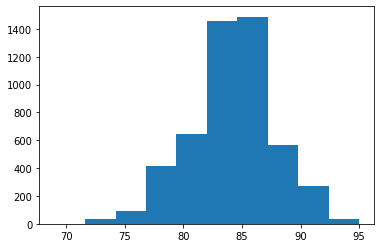

In [43]:
agents = 100 # number of agents
threshold = 60 # threshold for attendance
strategies = 2 # number of strategies
# number of weeks back in predictor function
# AND number of weeks back to look when selecting a predictor
memory = 2
# number of rounds to run the simulation
n_iter = 1
trials = 5000

# random seed for numpy
seed=25


p = (1 - 0.4**strategies)
print(f"We expect agents to attend with probability {p}.")
print(f"Total weekly attendance should have mean {agents * p} and variance {agents * p * (1-p)}")

results = np.empty(trials)

rng = np.random.default_rng(seed)

for tr in range(trials):
    # each row is a strategy
    strats = [
        make_strategies(rng, strategies, memory) for _ in range(agents)
    ]

    start = np.array([0,100,0,100])

    # weekly attendance count
    # the first 2*memory weeks are randomly generated
    # to seed the strategies
    hist = np.hstack([start, np.zeros(n_iter)]).astype(int)

    # index of week
    # we need some starting history to begin making selections
    t = memory * 2

    # Record the index of the optimal strategy 
    # on each iteration.
    # each row corresponds to an agent
    # each column corresponds to a week
    best_strats = np.zeros((agents, len(hist)))

    # record each agent's prediction on each iteration
    pred_history = np.zeros((agents, len(hist)))

    # construct time windows for evaluating strategies

    # The columns begin at
    # t - m - 1 
    # t - m
    # ...
    # t - 1
    # t
    # as you go down the column you are looking back
    # to that week's history.
    # so the column beginning at *t - m - 1*
    # generates the prediction for week *t - m*
    # and the rightmost column generates a
    # prediction for next week.
    windows = np.vstack([
        hist[t-memory-i-1: t-i]
        for i in range(memory)
    ])

    for agent in range(agents):
        strat = strats[agent]
        # each row is a strategy
        # each column is predicted attendance
        # in increasing order.
        # the last column has the prediction for
        # next week
        predictions = strat.dot(windows)

        # these are the observations that we use to
        # to test our predictions.
        # note that the observation from column 0
        # is not used since its prediction would come
        # from a previous week's history.
        observations = windows[0, 1:]

        # calculate the absolute error of predictions
        # here, we discard the rightmost prediction as
        # this is the prediction for the future.
        # if we knew the correct answer for that,
        # we wouldn't need to predict it!
        errs = np.abs(predictions[:, :-1] - observations).sum(axis=1)

        best_strat = np.argmin(errs)
        best_strats[agent, t] = best_strat

        pred = strat[best_strat].dot(windows[:,-1])
        pred_history[agent, t] = pred

    hist[t] = (pred_history[:, t] < threshold).sum()
    results[tr] = hist[t]


plt.hist(results)

print(f"Average attendance: {results.mean()}")
print(f"Variance of attendance: {results.var()}")

We expect agents to attend with probability 0.36.
Total weekly attendance should have mean 36.0 and variance 23.04
Average attendance: 35.941
Variance of attendance: 23.150319


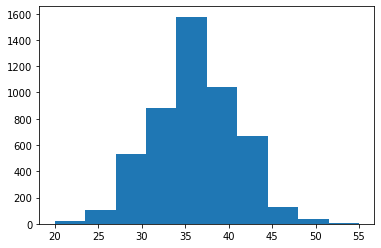

In [45]:
agents = 100 # number of agents
threshold = 60 # threshold for attendance
strategies = 2 # number of strategies
# number of weeks back in predictor function
# AND number of weeks back to look when selecting a predictor
memory = 2
# number of rounds to run the simulation
n_iter = 1
trials = 5000

# random seed for numpy
seed=25


p = (0.6**strategies)
print(f"We expect agents to attend with probability {p}.")
print(f"Total weekly attendance should have mean {agents * p} and variance {agents * p * (1-p)}")

results = np.empty(trials)

rng = np.random.default_rng(seed)

for tr in range(trials):
    # each row is a strategy
    strats = [
        make_strategies(rng, strategies, memory) for _ in range(agents)
    ]

    start = np.array([100,0,100,0])

    # weekly attendance count
    # the first 2*memory weeks are randomly generated
    # to seed the strategies
    hist = np.hstack([start, np.zeros(n_iter)]).astype(int)

    # index of week
    # we need some starting history to begin making selections
    t = memory * 2

    # Record the index of the optimal strategy 
    # on each iteration.
    # each row corresponds to an agent
    # each column corresponds to a week
    best_strats = np.zeros((agents, len(hist)))

    # record each agent's prediction on each iteration
    pred_history = np.zeros((agents, len(hist)))

    # construct time windows for evaluating strategies

    # The columns begin at
    # t - m - 1 
    # t - m
    # ...
    # t - 1
    # t
    # as you go down the column you are looking back
    # to that week's history.
    # so the column beginning at *t - m - 1*
    # generates the prediction for week *t - m*
    # and the rightmost column generates a
    # prediction for next week.
    windows = np.vstack([
        hist[t-memory-i-1: t-i]
        for i in range(memory)
    ])

    for agent in range(agents):
        strat = strats[agent]
        # each row is a strategy
        # each column is predicted attendance
        # in increasing order.
        # the last column has the prediction for
        # next week
        predictions = strat.dot(windows)

        # these are the observations that we use to
        # to test our predictions.
        # note that the observation from column 0
        # is not used since its prediction would come
        # from a previous week's history.
        observations = windows[0, 1:]

        # calculate the absolute error of predictions
        # here, we discard the rightmost prediction as
        # this is the prediction for the future.
        # if we knew the correct answer for that,
        # we wouldn't need to predict it!
        errs = np.abs(predictions[:, :-1] - observations).sum(axis=1)

        best_strat = np.argmin(errs)
        best_strats[agent, t] = best_strat

        pred = strat[best_strat].dot(windows[:,-1])
        pred_history[agent, t] = pred

    hist[t] = (pred_history[:, t] < threshold).sum()
    results[tr] = hist[t]


plt.hist(results)

print(f"Average attendance: {results.mean()}")
print(f"Variance of attendance: {results.var()}")

Whoo!  This is actually working and making sense!